# Prediction of the flow

### Decision tree regression with the rainfall feature
Model trained on the historical values of the flow, the value of the recent rainfall and/or value from previous hour

### Importing necessary libraries

In [57]:
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
import datetime as dt
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Loading the data sets

#### Rainfall data set

In [2]:
rainfall_set = pd.read_csv('../dataset/rainfall1.csv', parse_dates=['time'])
rainfall_set.head()

,time,rainfall
0,2014-10-24 00:00:00,0.0
1,2014-10-24 00:05:00,0.0
2,2014-10-24 00:10:00,0.0
3,2014-10-24 00:15:00,0.0
4,2014-10-24 00:20:00,0.0


In [3]:
rainfall_set.tail()

,time,rainfall
360143,2018-04-13 10:05:00,0.0
360144,2018-04-13 10:10:00,0.0
360145,2018-04-13 10:15:00,0.0
360146,2018-04-13 10:20:00,0.0
360147,2018-04-13 10:25:00,0.0


#### Flow data set

In [4]:
flow_set = pd.read_csv('../dataset/flow1.csv', parse_dates={'hour':['time']},index_col='hour')
dayfirst=True
flow_set = flow_set.resample('60T').mean()

In [5]:
flow_set = flow_set.reset_index()

In [6]:
flow_set['time'] = flow_set['hour']

In [7]:
flow_set.head()

,hour,flow,time
0,2015-06-01 14:00:00,113.754443,2015-06-01 14:00:00
1,2015-06-01 15:00:00,113.013333,2015-06-01 15:00:00
2,2015-06-01 16:00:00,114.081666,2015-06-01 16:00:00
3,2015-06-01 17:00:00,116.459167,2015-06-01 17:00:00
4,2015-06-01 18:00:00,123.825000,2015-06-01 18:00:00


### Leaving only a full hour as a feature

In [8]:
flow_set['hour'] = (flow_set['hour'].dt.hour)

In [9]:
flow_set.head()

,hour,flow,time
0,14,113.754443,2015-06-01 14:00:00
1,15,113.013333,2015-06-01 15:00:00
2,16,114.081666,2015-06-01 16:00:00
3,17,116.459167,2015-06-01 17:00:00
4,18,123.825000,2015-06-01 18:00:00


### Merging two data sets into one 
Merging is based on time column

In [10]:
flow_set = pd.merge(flow_set, rainfall_set, how='outer', on='time')

In [11]:
flow_set = flow_set.dropna()

In [12]:
flow_set.head()

,hour,flow,time,rainfall
0,14.0,113.754443,2015-06-01 14:00:00,0.0
1,15.0,113.013333,2015-06-01 15:00:00,0.0
2,16.0,114.081666,2015-06-01 16:00:00,0.0
3,17.0,116.459167,2015-06-01 17:00:00,0.0
4,18.0,123.825000,2015-06-01 18:00:00,0.0


### Adding the feature of previous hour's flow value

In [13]:
flow_set['previous-hour'] = flow_set['flow'].shift(1)

In [14]:
flow_set = flow_set.dropna()
flow_set.head()

,hour,flow,time,rainfall,previous-hour
1,15.0,113.013333,2015-06-01 15:00:00,0.0,113.754443
2,16.0,114.081666,2015-06-01 16:00:00,0.0,113.013333
3,17.0,116.459167,2015-06-01 17:00:00,0.0,114.081666
4,18.0,123.825000,2015-06-01 18:00:00,0.0,116.459167
5,19.0,128.884998,2015-06-01 19:00:00,0.0,123.825000


### General plot of rainfall in time

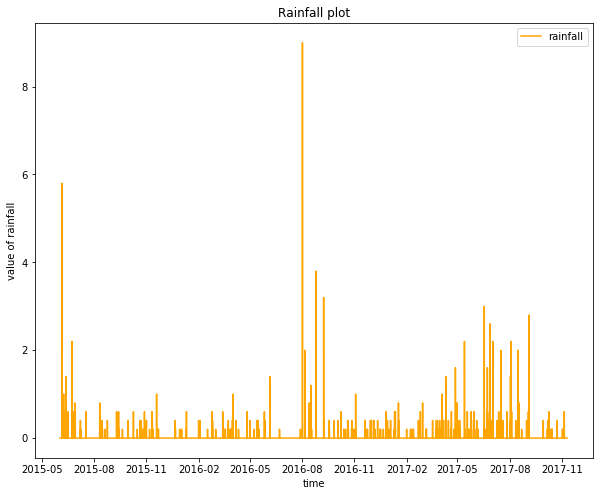

In [15]:
plt.figure(figsize=(10, 8))
plt.plot(flow_set['time'], flow_set['rainfall'], color="orange", label="rainfall")
plt.xlabel("time")
plt.ylabel("value of rainfall")
plt.title("Rainfall plot")
plt.legend()
plt.show()

### Rainfall plot of one month

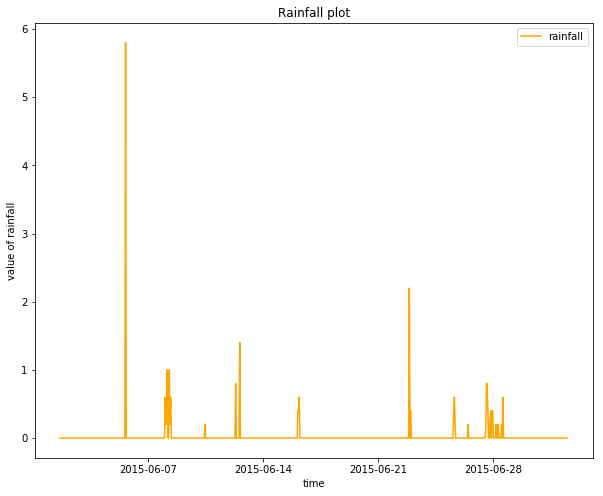

In [16]:
plt.figure(figsize=(10, 8))


dates = [pd.to_datetime(d) for d in flow_set['time']]
plt.plot(dates[:720], flow_set['rainfall'][:720], c = 'orange')

plt.xlabel("time")
plt.ylabel("value of rainfall")
plt.title("Rainfall plot")
plt.legend()
plt.show()

# Tree regression on two features
The features are the current hour and the rainfall from previous hour

In [17]:
flow_set.head()

,hour,flow,time,rainfall,previous-hour
1,15.0,113.013333,2015-06-01 15:00:00,0.0,113.754443
2,16.0,114.081666,2015-06-01 16:00:00,0.0,113.013333
3,17.0,116.459167,2015-06-01 17:00:00,0.0,114.081666
4,18.0,123.825000,2015-06-01 18:00:00,0.0,116.459167
5,19.0,128.884998,2015-06-01 19:00:00,0.0,123.825000


### Adding a column with value of the rainfall from previous hour

In [18]:
flow_set['previous-rainfall'] = flow_set['rainfall'].shift(1)

In [19]:
flow_set.head()

,hour,flow,time,rainfall,previous-hour,previous-rainfall
1,15.0,113.013333,2015-06-01 15:00:00,0.0,113.754443,NaN
2,16.0,114.081666,2015-06-01 16:00:00,0.0,113.013333,0.0
3,17.0,116.459167,2015-06-01 17:00:00,0.0,114.081666,0.0
4,18.0,123.825000,2015-06-01 18:00:00,0.0,116.459167,0.0
5,19.0,128.884998,2015-06-01 19:00:00,0.0,123.825000,0.0


In [20]:
flow_set.tail()

,hour,flow,time,rainfall,previous-hour,previous-rainfall
21428,10.0,120.655001,2017-11-10 10:00:00,0.0,128.465834,0.0
21429,11.0,115.167501,2017-11-10 11:00:00,0.0,120.655001,0.0
21430,12.0,111.554167,2017-11-10 12:00:00,0.0,115.167501,0.0
21431,13.0,109.408332,2017-11-10 13:00:00,0.0,111.554167,0.0
21432,14.0,107.245555,2017-11-10 14:00:00,0.0,109.408332,0.0


In [21]:
flow_set = flow_set.dropna()

### Splitting the data set into train and test sets

In [22]:
split_date = pd.datetime(2017,1,1,0,0)

flow_training = flow_set.loc[flow_set['time'] <= split_date]
flow_test = flow_set.loc[flow_set['time'] > split_date]

In [23]:
X_flow_training = flow_training[['hour','previous-rainfall']]
Y_flow_training = flow_training['flow']
X_flow_test = flow_test[['hour','previous-rainfall']]
Y_flow_test = flow_test['flow']

### Creating a multiple regression model with decision tree

In [24]:
regressor = DecisionTreeRegressor()
regressor.fit(X_flow_training, Y_flow_training)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [25]:
predict = regressor.predict(X_flow_test)

### Plot of the fragment of the model showing only the hour

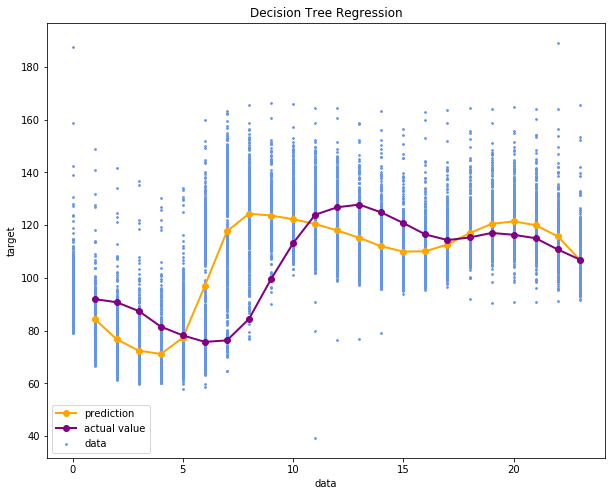

In [26]:
plt.figure(figsize=(10, 8))
plt.scatter(X_flow_training['hour'], Y_flow_training, s=3, 
            c="cornflowerblue", label="data")
plt.plot(X_flow_test['hour'][:23], predict[:23], color="orange",
         marker="o",label="prediction", linewidth=2)
plt.plot(X_flow_test['hour'][:23],Y_flow_test[:23], c='purple',marker="o", label="actual value",linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

### Feature_importances_
The importance in the model of the feature hour and the feature previous rainfall value

In [27]:
importance = regressor.feature_importances_

In [28]:
feature_importances = pd.DataFrame(regressor.feature_importances_,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
0,0.984396
1,0.015604


### Implementing metrics (mean absolute percentage error)

In [29]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### MAPE for tree regression with two features

In [30]:
mape_tree = mean_absolute_percentage_error(Y_flow_test, predict)
mape_tree

8.787056729542122

# Tree regression on three features

### Splitting the data set to train and test test

In [31]:
split_date = pd.datetime(2017,1,1,0,0)

flow_training2 = flow_set.loc[flow_set['time'] <= split_date]
flow_test2 = flow_set.loc[flow_set['time'] > split_date]

In [32]:
X_flow_training2 = flow_training2[['hour','previous-hour','previous-rainfall']]
Y_flow_training2 = flow_training2['flow']
X_flow_test2 = flow_test2[['hour','previous-hour','previous-rainfall']]
Y_flow_test2 = flow_test2['flow']

### Creating a multiple regression model with decision tree

In [33]:
regressor2 = DecisionTreeRegressor()
regressor2.fit(X_flow_training2, Y_flow_training2)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [34]:
predict2 = regressor2.predict(X_flow_test2)

### Plot of the fragment of the model showing only the hour

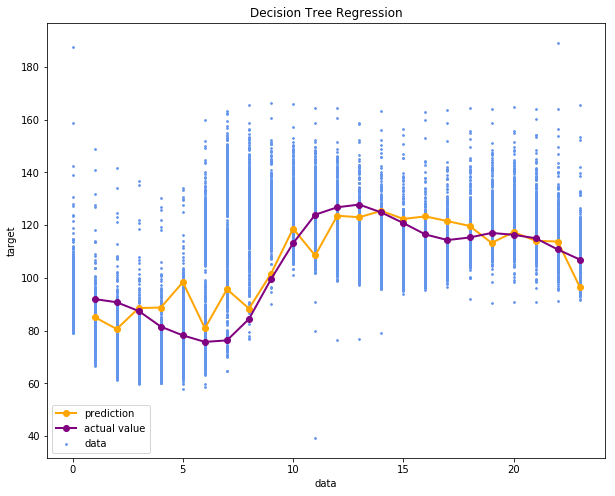

In [35]:
plt.figure(figsize=(10, 8))
plt.scatter(X_flow_training2['hour'], Y_flow_training2, s=3, 
            c="cornflowerblue", label="data")
plt.plot(X_flow_test2['hour'][:23], predict2[:23], color="orange",
         marker="o",label="prediction", linewidth=2)
plt.plot(X_flow_test2['hour'][:23],Y_flow_test2[:23], c='purple',marker="o", label="actual value",linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

### MAPE for tree regression for three features

In [36]:
mape_tree2 = mean_absolute_percentage_error(Y_flow_test2, predict2)
mape_tree2

3.8695849276282455

# Comparison with neural network

### Creating a model
MLPRegressor() from sklearn.neural_network

In [37]:
X = X_flow_training2[['hour','previous-hour','previous-rainfall']]
y = Y_flow_training2
test_x = X_flow_test2[['hour','previous-hour','previous-rainfall']]
test_y = Y_flow_test2
    
nn = MLPRegressor()
n = nn.fit(X, y.ravel())
predict_y = nn.predict(test_x)

### Plotting the fragment of the results showing only the hour feature

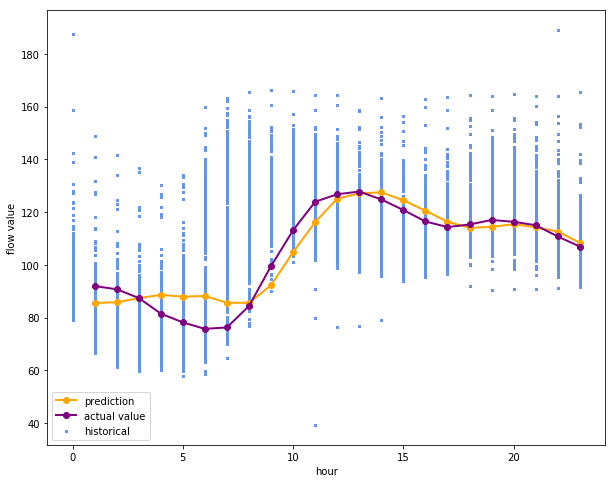

In [38]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)

plt.xlabel("hour")
plt.ylabel("flow value")

ax1.scatter(X['hour'], y, s=3, color="cornflowerblue", marker="s", label='historical')
plt.plot(test_x['hour'][:23],predict_y[:23], color='orange', marker="o", label="prediction",linewidth=2)
plt.plot(test_x['hour'][:23],test_y[:23], c='purple', marker="o", label="actual value",linewidth=2)
plt.legend()
plt.show()

### MAPE for the neural network

In [39]:
mape_neural = mean_absolute_percentage_error(Y_flow_test, predict_y)
mape_neural

4.951671497836578

### Principle Component Analysis (PCA) for Data Visualization 

In [46]:
flow_set.head()

,hour,flow,time,rainfall,previous-hour,previous-rainfall
2,16.0,114.081666,2015-06-01 16:00:00,0.0,113.013333,0.0
3,17.0,116.459167,2015-06-01 17:00:00,0.0,114.081666,0.0
4,18.0,123.825000,2015-06-01 18:00:00,0.0,116.459167,0.0
5,19.0,128.884998,2015-06-01 19:00:00,0.0,123.825000,0.0
6,20.0,128.890832,2015-06-01 20:00:00,0.0,128.884998,0.0


In [51]:
features = ['hour', 'rainfall', 'previous-hour','previous-rainfall']
x = flow_set.loc[:, features].values

In [52]:
y = flow_set.loc[:,['flow']].values

In [53]:
x = StandardScaler().fit_transform(x)

In [55]:
pd.DataFrame(data = x, columns = features).head()

,hour,rainfall,previous-hour,previous-rainfall
0,0.654679,-0.081426,0.158862,-0.081426
1,0.799647,-0.081426,0.204423,-0.081426
2,0.944616,-0.081426,0.305815,-0.081426
3,1.089584,-0.081426,0.619943,-0.081426
4,1.234552,-0.081426,0.835735,-0.081426
